In [16]:
%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
from torch import nn

from tbfm import tbfm, tbfm_phase_invariant
from tbfm.test import WaveDataGenerator, plot_grid_activity
from tbfm.utils import fft_circular_shift_per_basis


BATCH_SIZE = 5000
RUNWAY_LENGTH = 20
TRIAL_LENGTH = 184
N_DEPTH = 6
TRAIN_SET_SIZE = 3000
DEPTH_RUNWAY = 5
STIM_DIM = N_DEPTH * DEPTH_RUNWAY
DEVICE = 'cuda'

generator = WaveDataGenerator(
    grid_size=(8, 8),
    n_depth=N_DEPTH,
    time_steps=TRIAL_LENGTH,
    delay=RUNWAY_LENGTH-1,        # Wave emerges after 20 time steps
    ou_kappa=0.5,               # Strength of mean reversion
    ou_sigma=0.005                # Size of fluctuations
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


torch.Size([2000, 184, 6])


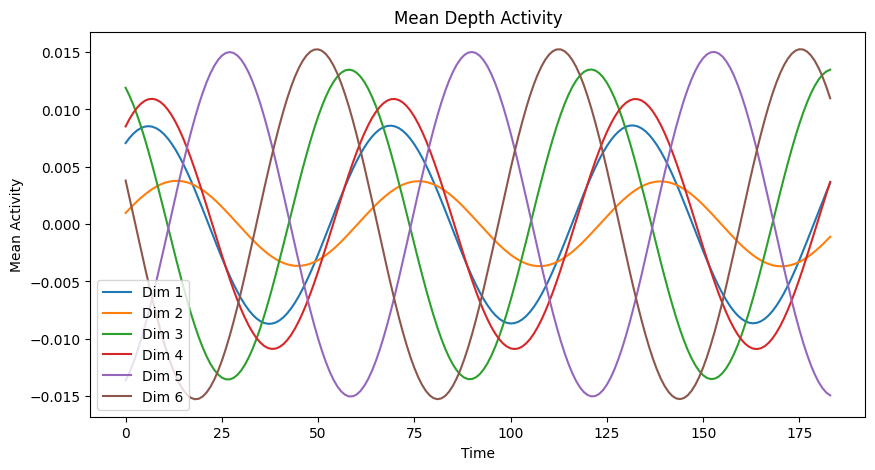

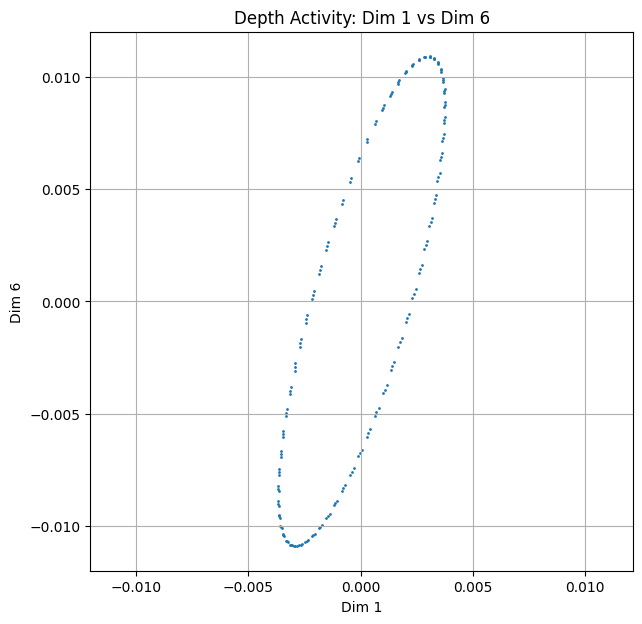

In [17]:
# Layer 5 / depth cells exhibit a linear and rotational dynamic.
da = generator.generate_depth_activity(2000)
print(da.shape)

means = da.mean(dim=0)
# Graph the dimensions
plt.figure(figsize=(10, 5))
for i in range(N_DEPTH):
    plt.plot(means[:, i], label=f"Dim {i + 1}")
plt.title("Mean Depth Activity")
plt.xlabel("Time")
plt.ylabel("Mean Activity")
plt.legend()
plt.show()

# And graph 1 versus 6 on x-y axes
plt.figure(figsize=(7, 7))
plt.scatter(means[:, 1], means[:, 3], s=1)
plt.title("Depth Activity: Dim 1 vs Dim 6")
plt.xlabel("Dim 1")
plt.ylabel("Dim 6")
plt.axis("equal")
plt.grid()
plt.show()


In [18]:
# Okay, now we should see a delayed traveling wave viewable on the cortical surface.
batch, params = generator.generate_batch(BATCH_SIZE)
print(batch.shape)

Source: (0.06, 7.98), Direction: 0.64, Radius: 22.37, Frequency: 0.0094, Speed: 2.8888, Amplitude: 0.50
Source: (2.46, 0.00), Direction: 6.28, Radius: 2.50, Frequency: 0.0050, Speed: 0.8866, Amplitude: 1.09
Source: (3.55, 0.00), Direction: 6.28, Radius: 2.50, Frequency: 0.0055, Speed: 1.6180, Amplitude: 2.36
Source: (0.07, 0.00), Direction: 6.28, Radius: 2.50, Frequency: 0.0050, Speed: 2.1847, Amplitude: 0.56
Source: (0.08, 7.99), Direction: 0.28, Radius: 22.45, Frequency: 0.0092, Speed: 2.8499, Amplitude: 0.50
Source: (7.98, 0.00), Direction: 6.07, Radius: 2.51, Frequency: 0.0050, Speed: 0.7796, Amplitude: 2.50
Source: (5.75, 0.07), Direction: 6.21, Radius: 2.57, Frequency: 0.0078, Speed: 1.7255, Amplitude: 2.45
Source: (0.00, 8.00), Direction: 5.78, Radius: 21.47, Frequency: 0.0100, Speed: 2.9983, Amplitude: 0.50
Source: (6.95, 7.99), Direction: 0.33, Radius: 22.33, Frequency: 0.0100, Speed: 2.4559, Amplitude: 2.44
Source: (7.59, 0.00), Direction: 5.75, Radius: 2.53, Frequency: 0.005

/home/mmattb/Projects/py-tbfm/tbfm/test.py:294: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_dt = torch.sqrt(torch.tensor(self.ou_sigma**2 / (2 * self.ou_kappa) *


torch.Size([5000, 184, 70])


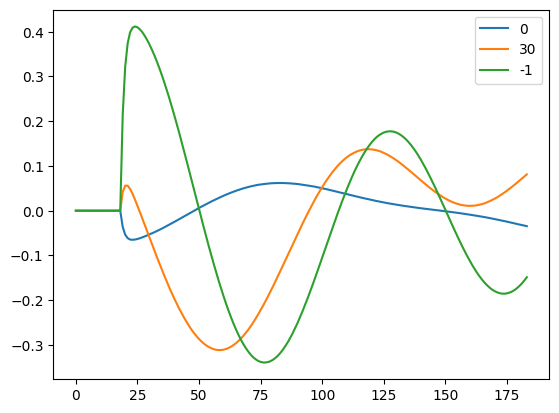

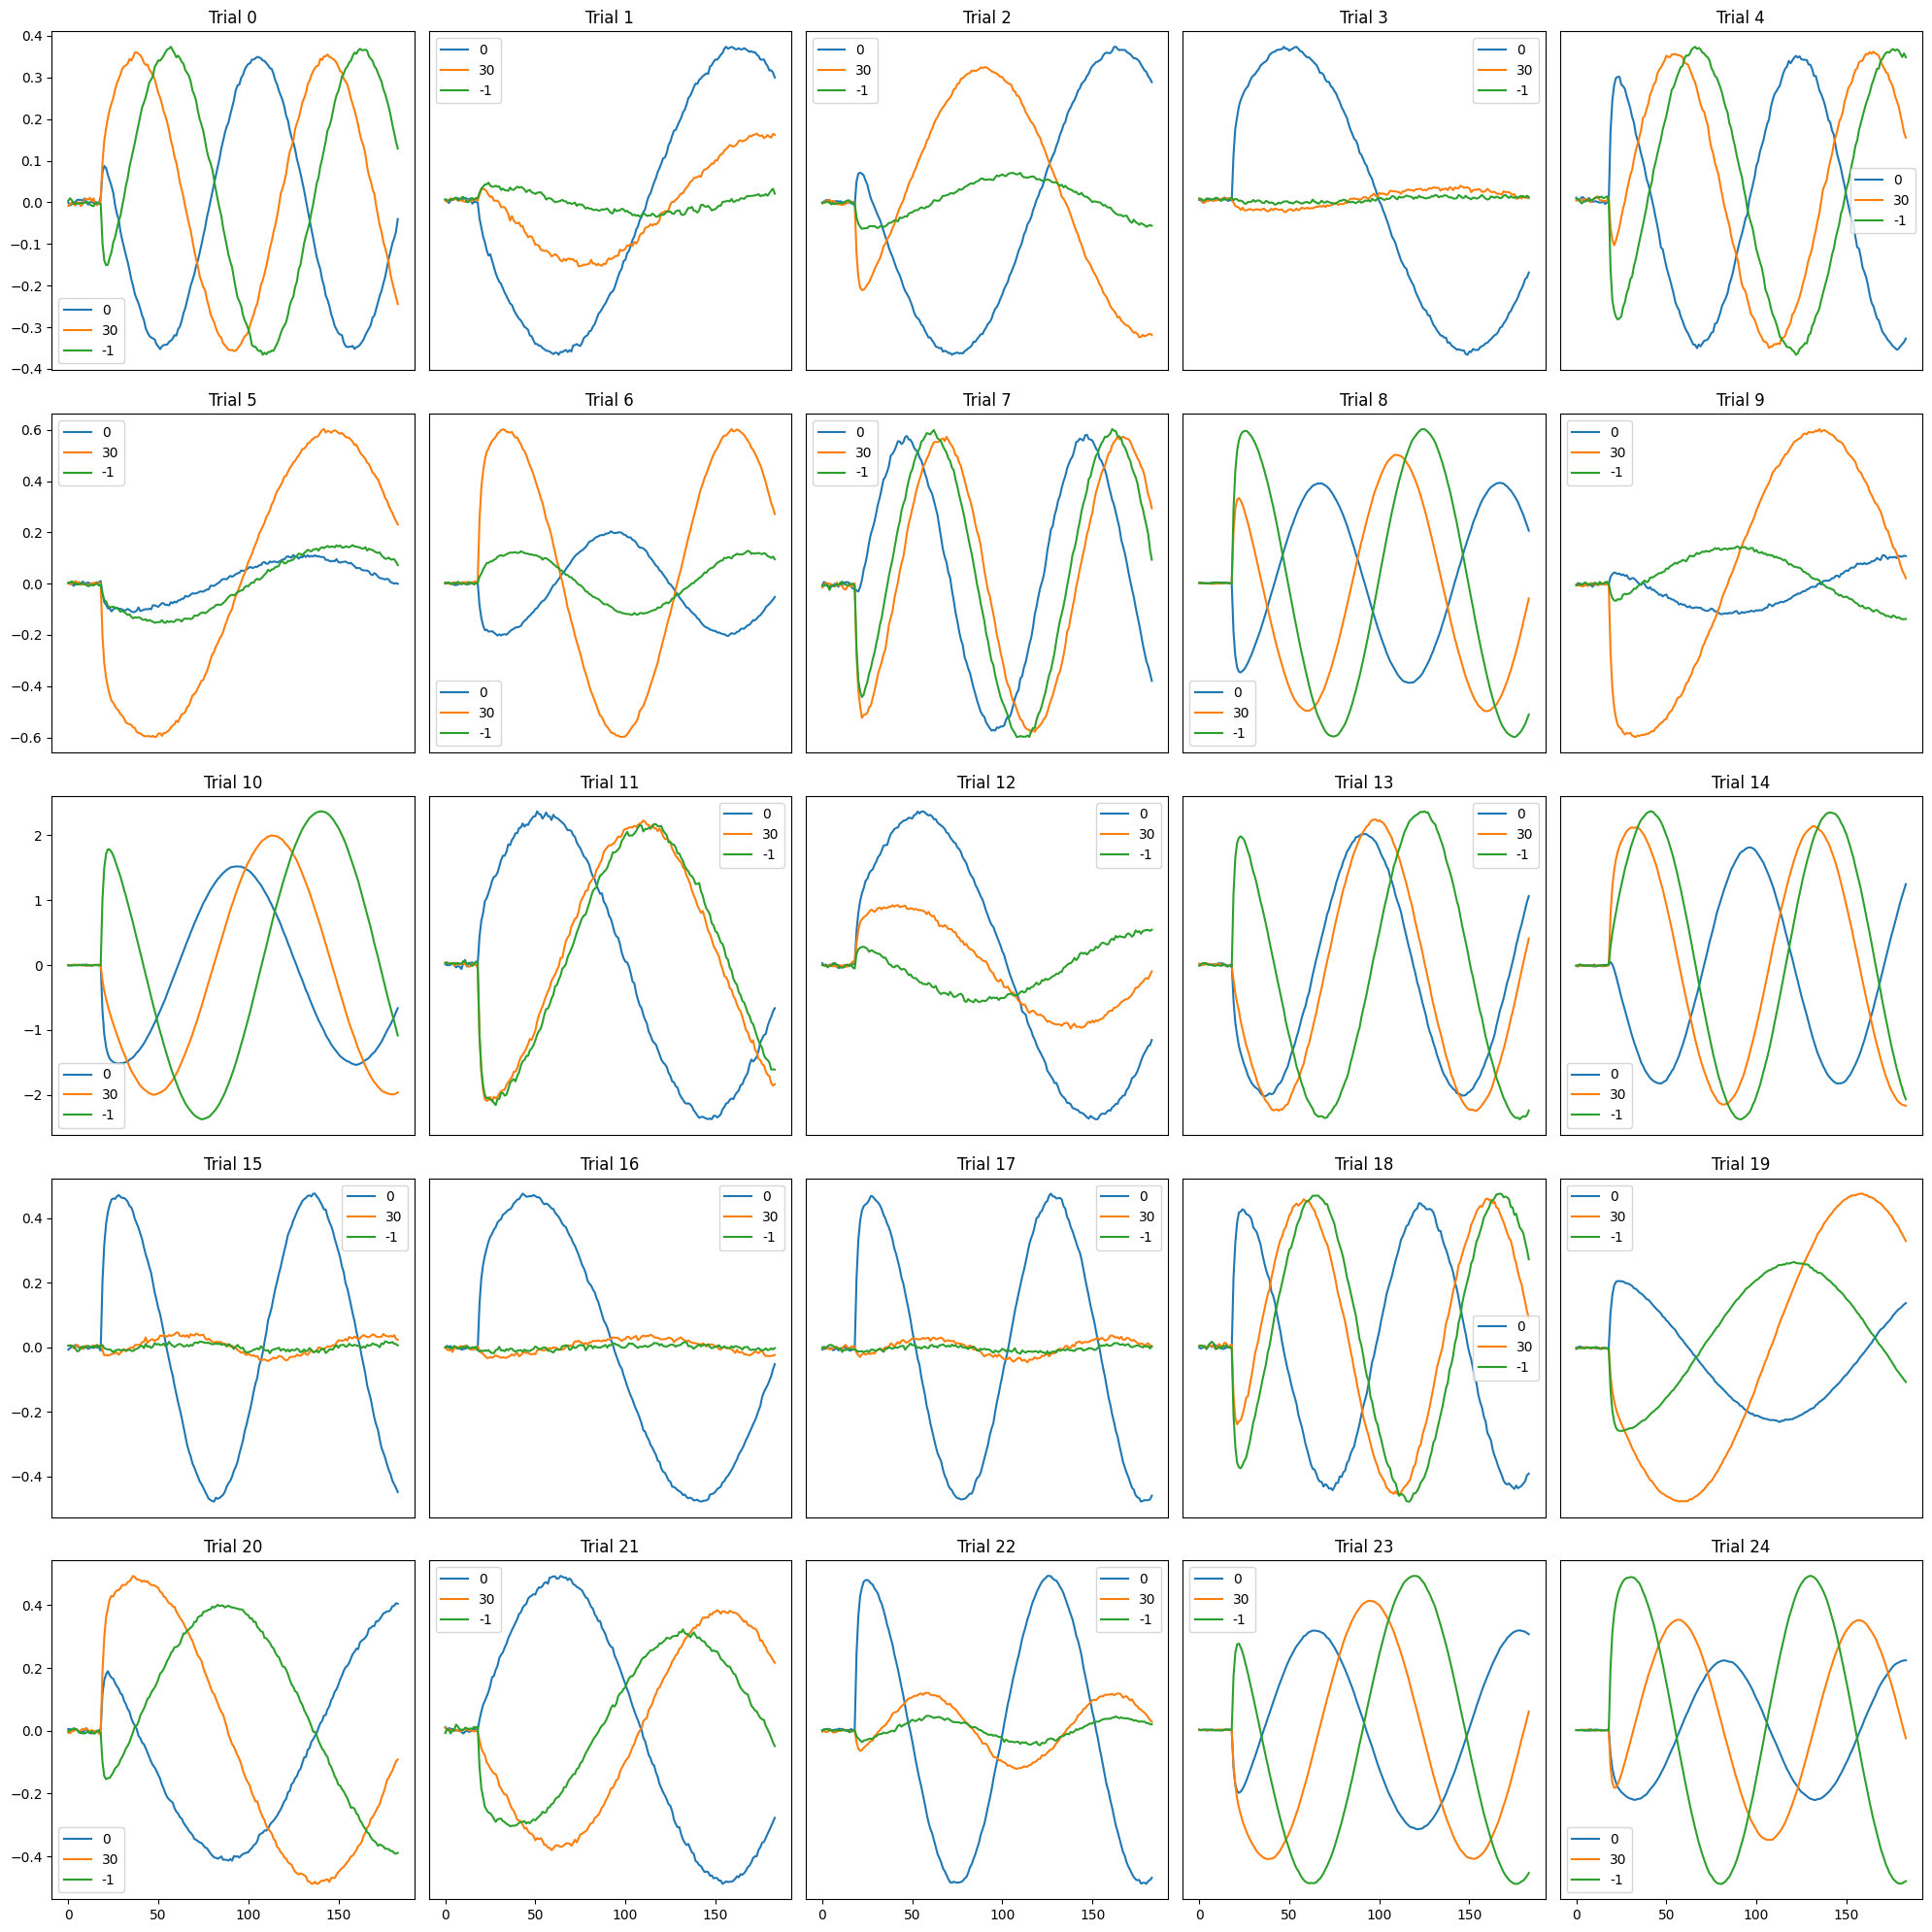

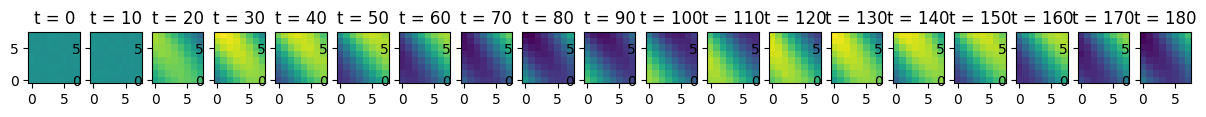

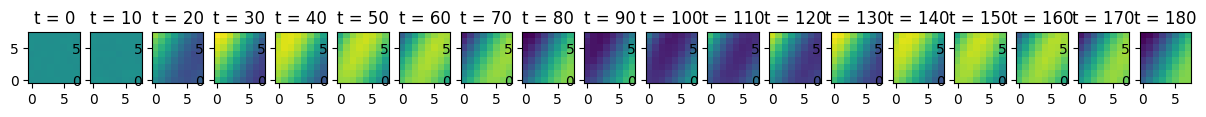

In [19]:
surface_activity = batch[:, :, :(batch.shape[2]-N_DEPTH)]
depth_activity = batch[:, :, -N_DEPTH:]

# Let's graph some various dimensions of the surfact activity. We should see wave-like activations.
means = torch.mean(surface_activity, dim=0)
plt.plot(means[:, 0], label='0')
plt.plot(means[:, 30], label='30')
plt.plot(means[:, -1], label='-1')
plt.legend()
plt.show()

fig, axes = plt.subplots(5, 5, figsize=(20, 20))
for i in range(5):
    for j in range(5):
        trial_idx = i*5 + j
        axes[i,j].plot(surface_activity[trial_idx, :, 0], label='0')
        axes[i,j].plot(surface_activity[trial_idx, :, 30], label='30')
        axes[i,j].plot(surface_activity[trial_idx, :, -1], label='-1')
        axes[i,j].set_title(f'Trial {trial_idx}')
        axes[i,j].legend()
        # Remove x-axis labels except bottom row
        if i != 4:
            axes[i,j].set_xticks([])
        # Remove y-axis labels except leftmost column
        if j != 0:
            axes[i,j].set_yticks([])

plt.tight_layout()
plt.show()

fig = plot_grid_activity(batch, batch_idx=0, timesteps=tuple(range(0, TRIAL_LENGTH, 10)))
plt.show()

fig = plot_grid_activity(batch, batch_idx=7, timesteps=tuple(range(0, TRIAL_LENGTH, 10)))
plt.show()

In [ ]:
# Good enough. Now let's run a base TBFM model. How do we want to set up the prediction problem?
# Maybe it looks at the depth activity and forward predicts the surface activity?
# Do we include the leading edge of the wave?
#
# Options:
# 1. Depth activity is theta somehow, regressor is the same as usual.
# 2. Depth and surface are both x values, regressor outputs both weights and phases, loss is only on surface predictions.
# 3. Base TBFM, x values are both depth and surface; thetas are 1s.

In [20]:
print(batch.shape)

def generate_train_test(batch, train_set_size=TRAIN_SET_SIZE, depth_is_x=True,
                        runway_length=RUNWAY_LENGTH, stim_dim=STIM_DIM, device=DEVICE,
                        depth_runway=DEPTH_RUNWAY):
    train_all = batch[:TRAIN_SET_SIZE, :, :]
    test_all = batch[TRAIN_SET_SIZE:, :, :]
    horizon = batch.shape[1] - runway_length
    test_set_size = test_all.shape[0]

    if not depth_is_x:
        # Depth activity is x, surface activity is theta
        train_x = train_all[:, :, :-N_DEPTH]
        train_theta = train_all[:, :, -N_DEPTH:]
        test_x = test_all[:, :, :-N_DEPTH]
        test_theta = test_all[:, :, -N_DEPTH:]

        train_theta = train_theta[:, :depth_runway, :].flatten(start_dim=1).unsqueeze(1).repeat(1, horizon, 1)
        test_theta = test_theta[:, :depth_runway, :].flatten(start_dim=1).unsqueeze(1).repeat(1, horizon, 1)
    else:
        # Depth and surface activity are both x, regressor outputs weights and phases
        train_x = train_all
        train_theta = torch.ones(train_set_size, horizon, stim_dim)
        test_x = test_all
        test_theta = torch.ones(test_set_size, horizon, stim_dim)

    train_runways = train_x[:, :runway_length, :]
    test_runways = test_x[:, :runway_length, :]
    train_y = train_x[:, runway_length:, :]
    test_y = test_x[:, runway_length:, :]

    return train_runways.to(DEVICE), train_y.to(DEVICE), train_theta.to(DEVICE), \
           test_runways.to(DEVICE), test_y.to(DEVICE), test_theta.to(DEVICE)


torch.Size([5000, 184, 70])


In [ ]:
NUM_BASES = 45
LATENT_DIM = 2
BASIS_DEPTH = 2
train_runways, train_y, train_theta, test_runways, test_y, test_theta = generate_train_test(
    batch, depth_is_x=True)
num_channels = train_runways.shape[2]
model = tbfm.TBFM(num_channels, STIM_DIM, RUNWAY_LENGTH, NUM_BASES, TRIAL_LENGTH-RUNWAY_LENGTH,
                  batchy=train_y,
                  latent_dim=LATENT_DIM,
                  basis_depth=BASIS_DEPTH,
                  device=DEVICE)
optim = model.get_optim(lr=2e-4)


torch.Size([3000, 184, 70]) torch.Size([2000, 184, 70])


In [53]:
NUM_EPOCHS = 10000
TEST_EPOCH_INTERVAL = 1000  # We will run against the test set every so often to monitor progress
LAMBDA = 0.01

losses_train = []
losses_test = []

# Now z score our y values using the comming means/stdevs from the training set.
# Runways are z scored by the model on the fly, and y_hats will be in that z-scored space
y_train = model.zscore(train_y)
y_test = model.zscore(test_y)
start_time = time.time()
for eidx in range(NUM_EPOCHS):
    optim.zero_grad()
    
    yhat_train = model(train_runways, train_theta)
    
    # Loss will be based on surface activity predictions only.
    loss = nn.MSELoss()(yhat_train[:, :, :-N_DEPTH], y_train[:, :, :-N_DEPTH]) 

    l1w = model.get_weighting_reg()
    (loss + LAMBDA * l1w).backward()
          
    losses_train.append((eidx, loss.item()))
    optim.step()
    
    if (eidx % TEST_EPOCH_INTERVAL) == 0:        
        with torch.no_grad():
            yhat_test = model(test_runways, test_theta)
    
            loss = nn.MSELoss()(yhat_test[:, :, :-N_DEPTH], y_test[:, :, :-N_DEPTH])
            losses_test.append((eidx, loss.item()))
            
        print(f"epoch: {eidx}, train loss: {losses_train[-1][1]}, test loss: {losses_test[-1][1]}")

print(f"Training time: {time.time() - start_time}")

epoch: 0, train loss: 1.8379247188568115, test loss: 1.7788974046707153
epoch: 1000, train loss: 0.368735134601593, test loss: 0.3889111578464508
epoch: 2000, train loss: 0.3583088219165802, test loss: 0.37945500016212463
epoch: 3000, train loss: 0.3532693684101105, test loss: 0.37507858872413635
epoch: 4000, train loss: 0.3496171832084656, test loss: 0.3719440996646881
epoch: 5000, train loss: 0.3467206656932831, test loss: 0.369473934173584
epoch: 6000, train loss: 0.3441612124443054, test loss: 0.3674774467945099
epoch: 7000, train loss: 0.3415515124797821, test loss: 0.3652375042438507
epoch: 8000, train loss: 0.3386538624763489, test loss: 0.36322906613349915
epoch: 9000, train loss: 0.3360380530357361, test loss: 0.36106547713279724
Training time: 255.6344084739685


In [2]:
# Plot some example test set predictions versus ground truth.
def graph_preds(test_y, yhat_test, ch=10):
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    for i in range(5):
        for j in range(5):
            trial_idx = i*5 + j
            axes[i,j].plot(test_y[trial_idx, :, ch].cpu().numpy(), label='Ground Truth 10')
            axes[i,j].plot(yhat_test[trial_idx, :, ch].cpu().numpy(), label='Predicted 10')
            axes[i,j].set_title(f'Trial {trial_idx}')
            axes[i,j].legend()
            # Remove x-axis labels except bottom row
            if i != 4:
                axes[i,j].set_xticks([])
            # Remove y-axis labels except leftmost column
            if j != 0:
                axes[i,j].set_yticks([])
    plt.tight_layout()
    plt.show()

graph_preds(test_y, yhat_test, ch=10)

NameError: name 'test_y' is not defined

In [6]:
# Okay, now let's pass the depth activity somehow as theta values.
# X and Y values will be surface activity.
NUM_BASES = 60
LATENT_DIM = 6
BASIS_DEPTH = 4
train_runways, train_y, train_theta, test_runways, test_y, test_theta = generate_train_test(
    batch, depth_is_x=False)
num_channels = train_runways.shape[2]
model = tbfm.TBFM(num_channels, STIM_DIM, RUNWAY_LENGTH, NUM_BASES, TRIAL_LENGTH-RUNWAY_LENGTH,
                  batchy=train_y,
                  latent_dim=LATENT_DIM,
                  basis_depth=BASIS_DEPTH,
                  device=DEVICE)
optim = model.get_optim(lr=2e-4)


In [3]:
NUM_EPOCHS = 20000
TEST_EPOCH_INTERVAL = 1000  # We will run against the test set every so often to monitor progress
LAMBDA = 0.01

losses_train = []
losses_test = []

# Now z score our y values using the comming means/stdevs from the training set.
# Runways are z scored by the model on the fly, and y_hats will be in that z-scored space
y_train = model.zscore(train_y)
y_test = model.zscore(test_y)
start_time = time.time()
for eidx in range(NUM_EPOCHS):
    optim.zero_grad()
    
    yhat_train = model(train_runways, train_theta)
    
    # Loss will be based on surface activity predictions only.
    loss = nn.MSELoss()(yhat_train[:, :, :-N_DEPTH], y_train[:, :, :-N_DEPTH]) 

    l1w = model.get_weighting_reg()
    (loss + LAMBDA * l1w).backward()
          
    losses_train.append((eidx, loss.item()))
    optim.step()
    
    if (eidx % TEST_EPOCH_INTERVAL) == 0:        
        with torch.no_grad():
            yhat_test = model(test_runways, test_theta)
    
            loss = nn.MSELoss()(yhat_test[:, :, :-N_DEPTH], y_test[:, :, :-N_DEPTH])
            losses_test.append((eidx, loss.item()))
            
        print(f"epoch: {eidx}, train loss: {losses_train[-1][1]}, test loss: {losses_test[-1][1]}")

print(f"Training time: {time.time() - start_time}")

NameError: name 'model' is not defined

In [1]:
graph_preds(test_y, yhat_test, ch=10)

NameError: name 'graph_preds' is not defined

In [7]:
# Alright that's looking better. Let's bind the whole thing up in a function and grid search
#  the hyperparameters.
def run_tbfm(batch, depth_is_x=True, num_bases=45, latent_dim=5, basis_depth=5,
             num_epochs=20000, test_epoch_interval=1000, lr=2e-4, lambda_reg=0.01,
             device=DEVICE):
    train_runways, train_y, train_theta, test_runways, test_y, test_theta = generate_train_test(
        batch, depth_is_x=depth_is_x)
    num_channels = train_runways.shape[2]
    
    model = tbfm.TBFM(num_channels, STIM_DIM, RUNWAY_LENGTH, num_bases,
                      TRIAL_LENGTH-RUNWAY_LENGTH,
                      batchy=train_y,
                      latent_dim=latent_dim,
                      basis_depth=basis_depth,
                      device=device)
    optim = model.get_optim(lr=lr)

    losses_train = []
    losses_test = []

    # Now z score our y values using the comming means/stdevs from the training set.
    # Runways are z scored by the model on the fly, and y_hats will be in that z-scored space
    y_train = model.zscore(train_y)
    y_test = model.zscore(test_y)
    
    start_time = time.time()
    for eidx in range(num_epochs):
        optim.zero_grad()

        yhat_train = model(train_runways, train_theta)

        # Loss will be based on surface activity predictions only.
        loss = nn.MSELoss()(yhat_train[:, :, :-N_DEPTH], y_train[:, :, :-N_DEPTH]) 

        l1w = model.get_weighting_reg()
        (loss + lambda_reg * l1w).backward()

        losses_train.append((eidx, loss.item()))
        optim.step()

        if (eidx % test_epoch_interval) == 0:        
            with torch.no_grad():
                yhat_test = model(test_runways, test_theta)

                loss = nn.MSELoss()(yhat_test[:, :, :-N_DEPTH], y_test[:, :, :-N_DEPTH])
                losses_test.append((eidx, loss.item()))

            print(f"epoch: {eidx}, train loss: {losses_train[-1][1]}, test loss: {losses_test[-1][1]}")

    return model, losses_train, losses_test

# Now let's run a grid search over the hyperparameters.
def grid_search(batch, depth_is_x=True, num_bases_list=[10, 15, 30, 45, 60], latent_dim_list=[2, 4, 6],
                basis_depth_list=[2, 4, 6], num_epochs=20000, test_epoch_interval=1000,
                lr=2e-4, lambda_reg=0.01, device=DEVICE):
    results = []
    parameters = []
    for num_bases in num_bases_list:
        for latent_dim in latent_dim_list:
            for basis_depth in basis_depth_list:
                print(f"Running TBFM with num_bases={num_bases}, latent_dim={latent_dim}, "
                      f"basis_depth={basis_depth}")
                model, losses_train, losses_test = run_tbfm(
                    batch, depth_is_x=depth_is_x, num_bases=num_bases,
                    latent_dim=latent_dim, basis_depth=basis_depth,
                    num_epochs=num_epochs, test_epoch_interval=test_epoch_interval,
                    lr=lr, lambda_reg=lambda_reg, device=device)
                results.append((model, losses_train, losses_test))
                parameters.append((num_bases, latent_dim, basis_depth))

                print(f"------ {parameters}: {results[-1][-1]}")

    return results, parameters

In [8]:
results, parameters = grid_search(batch, depth_is_x=False)

Running TBFM with num_bases=10, latent_dim=2, basis_depth=2
epoch: 0, train loss: 1.234682321548462, test loss: 1.2206203937530518
epoch: 1000, train loss: 0.17979644238948822, test loss: 0.1772872656583786
epoch: 2000, train loss: 0.11641848832368851, test loss: 0.11544051021337509
epoch: 3000, train loss: 0.09783358126878738, test loss: 0.09726114571094513
epoch: 4000, train loss: 0.08764498680830002, test loss: 0.08731892704963684
epoch: 5000, train loss: 0.08102747052907944, test loss: 0.08090189844369888
epoch: 6000, train loss: 0.0731666088104248, test loss: 0.07333825528621674
epoch: 7000, train loss: 0.04829704761505127, test loss: 0.04871523007750511
epoch: 8000, train loss: 0.029216481372714043, test loss: 0.029723118990659714
epoch: 9000, train loss: 0.025726664811372757, test loss: 0.02617356926202774
epoch: 10000, train loss: 0.02374623715877533, test loss: 0.024209173396229744
epoch: 11000, train loss: 0.02208595722913742, test loss: 0.022614218294620514
epoch: 12000, tra

In [ ]:
#Running TBFM with num_bases=10, latent_dim=2, basis_depth=2
#epoch: 19000, train loss: 0.014197495765984058, test loss: 0.014744681306183338
#Running TBFM with num_bases=10, latent_dim=2, basis_depth=4
#epoch: 19000, train loss: 0.014879189431667328, test loss: 0.015470178797841072
#Running TBFM with num_bases=10, latent_dim=2, basis_depth=6
#epoch: 19000, train loss: 0.014100740663707256, test loss: 0.014556683599948883
#Running TBFM with num_bases=10, latent_dim=4, basis_depth=2
#epoch: 19000, train loss: 0.008696974255144596, test loss: 0.009136708453297615
#Running TBFM with num_bases=10, latent_dim=4, basis_depth=4
#epoch: 19000, train loss: 0.009028514847159386, test loss: 0.00943389255553484
#Running TBFM with num_bases=10, latent_dim=4, basis_depth=6
#epoch: 19000, train loss: 0.0085842190310359, test loss: 0.009073465131223202
#Running TBFM with num_bases=10, latent_dim=6, basis_depth=2
#epoch: 19000, train loss: 0.006976317148655653, test loss: 0.007326291874051094
#Running TBFM with num_bases=10, latent_dim=6, basis_depth=4
#epoch: 19000, train loss: 0.00640058470889926, test loss: 0.00668905908241868
#Running TBFM with num_bases=10, latent_dim=6, basis_depth=6
#epoch: 19000, train loss: 0.007443518377840519, test loss: 0.008037850260734558
#Running TBFM with num_bases=15, latent_dim=2, basis_depth=2
#epoch: 19000, train loss: 0.013250843621790409, test loss: 0.013891469687223434
#Running TBFM with num_bases=15, latent_dim=2, basis_depth=4
#epoch: 19000, train loss: 0.013361969962716103, test loss: 0.013793675228953362
#Running TBFM with num_bases=15, latent_dim=2, basis_depth=6
#epoch: 19000, train loss: 0.014654694125056267, test loss: 0.01556345634162426
#Running TBFM with num_bases=15, latent_dim=4, basis_depth=2
#epoch: 19000, train loss: 0.007701133843511343, test loss: 0.008154425770044327
#Running TBFM with num_bases=15, latent_dim=4, basis_depth=4
#epoch: 19000, train loss: 0.008217943832278252, test loss: 0.008642359636723995
#Running TBFM with num_bases=15, latent_dim=4, basis_depth=6
#epoch: 19000, train loss: 0.008069515228271484, test loss: 0.008381140418350697
#Running TBFM with num_bases=15, latent_dim=6, basis_depth=2
#epoch: 19000, train loss: 0.005891760811209679, test loss: 0.00609961524605751
#Running TBFM with num_bases=15, latent_dim=6, basis_depth=4
#epoch: 19000, train loss: 0.006160747725516558, test loss: 0.006527045741677284
#Running TBFM with num_bases=15, latent_dim=6, basis_depth=6
#epoch: 19000, train loss: 0.006282968912273645, test loss: 0.006643236149102449
#Running TBFM with num_bases=30, latent_dim=2, basis_depth=2
#epoch: 19000, train loss: 0.01254298910498619, test loss: 0.013120551593601704
#Running TBFM with num_bases=30, latent_dim=2, basis_depth=4
#epoch: 19000, train loss: 0.012575943022966385, test loss: 0.013222252018749714
#Running TBFM with num_bases=30, latent_dim=2, basis_depth=6
#epoch: 19000, train loss: 0.0118057606741786, test loss: 0.01248007733374834
#Running TBFM with num_bases=30, latent_dim=4, basis_depth=2
#epoch: 19000, train loss: 0.006593042518943548, test loss: 0.006881896872073412
#Running TBFM with num_bases=30, latent_dim=4, basis_depth=4
#epoch: 19000, train loss: 0.0073911212384700775, test loss: 0.007548075634986162
#Running TBFM with num_bases=30, latent_dim=4, basis_depth=6
#epoch: 19000, train loss: 0.007586463820189238, test loss: 0.007712308317422867
#Running TBFM with num_bases=30, latent_dim=6, basis_depth=2
#epoch: 19000, train loss: 0.005473111756145954, test loss: 0.005844946019351482
#Running TBFM with num_bases=30, latent_dim=6, basis_depth=4
#epoch: 19000, train loss: 0.005970085971057415, test loss: 0.006379331462085247
#Running TBFM with num_bases=30, latent_dim=6, basis_depth=6
#epoch: 19000, train loss: 0.0055705285631120205, test loss: 0.006250051781535149
#Running TBFM with num_bases=45, latent_dim=2, basis_depth=2
#epoch: 19000, train loss: 0.008769839070737362, test loss: 0.009051407687366009
#Running TBFM with num_bases=45, latent_dim=2, basis_depth=4
#epoch: 19000, train loss: 0.010153462179005146, test loss: 0.010695078410208225
#Running TBFM with num_bases=45, latent_dim=2, basis_depth=6
#epoch: 19000, train loss: 0.011111488565802574, test loss: 0.011650009080767632
#Running TBFM with num_bases=45, latent_dim=4, basis_depth=2
#epoch: 19000, train loss: 0.006318317726254463, test loss: 0.006686017848551273
#Running TBFM with num_bases=45, latent_dim=4, basis_depth=4
#epoch: 19000, train loss: 0.005925124976783991, test loss: 0.006204522214829922
#Running TBFM with num_bases=45, latent_dim=4, basis_depth=6
#epoch: 19000, train loss: 0.0065668984316289425, test loss: 0.006962622050195932
#Running TBFM with num_bases=45, latent_dim=6, basis_depth=2
#epoch: 19000, train loss: 0.004806466866284609, test loss: 0.005106459837406874
#Running TBFM with num_bases=45, latent_dim=6, basis_depth=4
#epoch: 19000, train loss: 0.004612373653799295, test loss: 0.004843064583837986
#Running TBFM with num_bases=45, latent_dim=6, basis_depth=6
#epoch: 19000, train loss: 0.006474277935922146, test loss: 0.0064454288221895695
#Running TBFM with num_bases=60, latent_dim=2, basis_depth=2
#epoch: 19000, train loss: 0.014214040711522102, test loss: 0.013813267461955547
#Running TBFM with num_bases=60, latent_dim=2, basis_depth=4
#epoch: 19000, train loss: 0.010844103060662746, test loss: 0.011351611465215683
#Running TBFM with num_bases=60, latent_dim=2, basis_depth=6
#epoch: 19000, train loss: 0.011569853872060776, test loss: 0.012106413021683693
#Running TBFM with num_bases=60, latent_dim=4, basis_depth=2
#epoch: 19000, train loss: 0.006175645161420107, test loss: 0.006669437047094107
#Running TBFM with num_bases=60, latent_dim=4, basis_depth=4
#epoch: 19000, train loss: 0.005677637178450823, test loss: 0.005947322119027376
#Running TBFM with num_bases=60, latent_dim=4, basis_depth=6
#epoch: 19000, train loss: 0.0065521420910954475, test loss: 0.0069420672953128815
#Running TBFM with num_bases=60, latent_dim=6, basis_depth=2
#epoch: 19000, train loss: 0.004397351760417223, test loss: 0.004584894049912691  <------
#Running TBFM with num_bases=60, latent_dim=6, basis_depth=4
#epoch: 19000, train loss: 0.007480198983103037, test loss: 0.006487438455224037
#Running TBFM with num_bases=60, latent_dim=6, basis_depth=6
#epoch: 19000, train loss: 0.004864504095166922, test loss: 0.005099095869809389


torch.save((results, parameters), 'tbfm_grid_search_results.pth')

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


[]

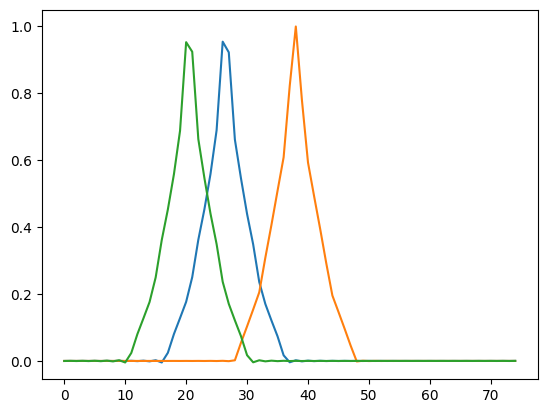

In [ ]:
# That's exactly the findings I expected: we can model traveling waves with a TBFM but we need a
# ton of basis functions to do it.

# Now for phase invariant TBFMs...

# Let's test our phase shifter.

# Something we can shift and graph for a quick test
# (batch_size, num_bases, trial_len)
bases = torch.zeros(100, 3, 75)
# Just a one-hot
bases[:, :, 20] = 1
bases[:, :, 19] = 0.8
bases[:, :, 21] = 0.8
bases[:, :, 18] = 0.6
bases[:, :, 22] = 0.6
bases[:, :, 17] = 0.5
bases[:, :, 23] = 0.5
bases[:, :, 16] = 0.4
bases[:, :, 24] = 0.4
bases[:, :, 15] = 0.3
bases[:, :, 25] = 0.3
bases[:, :, 14] = 0.2
bases[:, :, 26] = 0.2
bases[:, :, 13] = 0.15
bases[:, :, 27] = 0.15
bases[:, :, 12] = 0.10
bases[:, :, 28] = 0.10
bases[:, :, 11] = 0.05
bases[:, :, 29] = 0.05

# (batch_size, in_dim, num_bases)
phases = torch.randn(100, 5, 3) * 4

# (batch_size, in_dim, num_bases, trial_len)
shifted_bases = fft_circular_shift_per_basis(bases, phases)

# For two random batch elements and two random (in_dim, basis) combinations, graph the shifted basis.
for _ in range(3):
    bidx = random.randrange(100)
    cidx = random.randrange(5)
    baidx = random.randrange(3)
    plt.plot(shifted_bases[bidx, cidx, baidx, :])
plt.plot()

In [30]:
# Seems to work. Let's try the shift invariant TBFM.
NUM_BASES = 60
LATENT_DIM = 6
BASIS_DEPTH = 4
train_runways, train_y, train_theta, test_runways, test_y, test_theta = generate_train_test(
    batch, depth_is_x=False)
num_channels = train_runways.shape[2]
model = tbfm_phase_invariant.TBFMPi(num_channels, STIM_DIM, RUNWAY_LENGTH, NUM_BASES,
                  TRIAL_LENGTH-RUNWAY_LENGTH,
                  batchy=train_y,
                  latent_dim=LATENT_DIM,
                  basis_depth=BASIS_DEPTH,
                  device=DEVICE)
optim = model.get_optim(lr=2e-4)


In [31]:
NUM_EPOCHS = 20000
TEST_EPOCH_INTERVAL = 1000  # We will run against the test set every so often to monitor progress
LAMBDA = 0.01

losses_train = []
losses_test = []

# Now z score our y values using the comming means/stdevs from the training set.
# Runways are z scored by the model on the fly, and y_hats will be in that z-scored space
y_train = model.zscore(train_y)
y_test = model.zscore(test_y)
start_time = time.time()
for eidx in range(NUM_EPOCHS):
    optim.zero_grad()
    
    yhat_train = model(train_runways, train_theta)
    
    # Loss will be based on surface activity predictions only.
    loss = nn.MSELoss()(yhat_train[:, :, :-N_DEPTH], y_train[:, :, :-N_DEPTH]) 

    l1w = model.get_weighting_reg()
    (loss + LAMBDA * l1w).backward()
          
    losses_train.append((eidx, loss.item()))
    optim.step()
    
    if (eidx % TEST_EPOCH_INTERVAL) == 0:        
        with torch.no_grad():
            yhat_test = model(test_runways, test_theta)
    
            loss = nn.MSELoss()(yhat_test[:, :, :-N_DEPTH], y_test[:, :, :-N_DEPTH])
            losses_test.append((eidx, loss.item()))
            
        print(f"epoch: {eidx}, train loss: {losses_train[-1][1]}, test loss: {losses_test[-1][1]}")

print(f"Training time: {time.time() - start_time}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.08 GiB. GPU 0 has a total capacity of 7.65 GiB of which 5.57 GiB is free. Including non-PyTorch memory, this process has 2.06 GiB memory in use. Of the allocated memory 1.66 GiB is allocated by PyTorch, and 265.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [26]:
print(model.basis_weights_and_phases.weight.shape)

torch.Size([7680, 1280])


In [29]:
print(7680/(64*60))

2.0
